In [1]:
# Standard library imports
import os

# Third-party imports

# General utilities
import holidays
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

# TensorFlow
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv1D, Dense, Dropout, Flatten, Input, Lambda, LSTM, MaxPooling1D
)
from tensorflow.keras.models import Model

# Local imports
from pauls_data_loaders import loader_functions

# Silence TensorFlow messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Pandas display options
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)


2024-12-08 12:20:26.806097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load data

In [2]:
data = loader_functions.load_all_data()

In [7]:
data.columns

Index(['zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5', 'zone_6', 'zone_7',
       'zone_8', 'zone_9', 'zone_10', 'zone_11', 'zone_12', 'zone_13',
       'zone_14', 'zone_15', 'zone_16', 'zone_17', 'zone_18', 'zone_19',
       'zone_20', 'station_1', 'station_2', 'station_3', 'station_4',
       'station_5', 'station_6', 'station_7', 'station_8', 'station_9',
       'station_10', 'station_11'],
      dtype='object')

In [22]:
w = loader_functions.load_weights()
w = w.reindex(data.index).fillna(0)
w

zone_id,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,zone_10,zone_11,zone_12,zone_13,zone_14,zone_15,zone_16,zone_17,zone_18,zone_19,zone_20,zone_21
datetime,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-06-30 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-06-30 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-06-30 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# LSTM CNN

## Model Constructor Def

In [3]:
# sequence_length: number of timesteps in the sequence
#     feature_dim: number of features in each timestep
def lstm_cnn(sequence_length, feature_dim, show=False):
    # define shape of input
    input_shape = (sequence_length, feature_dim)
    
    # construct input layer
    inputs = Input(shape=input_shape)

    # construct CNN layers
    cnn = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs)
    cnn = MaxPooling1D(pool_size=2)(cnn)
    cnn = Flatten()(cnn)

    # Define a Lambda layer to reshape the CNN output for LSTM
    lstm_input = Lambda(lambda x: tf.expand_dims(x, axis=1))(cnn)
    
    # construct LSTM layers
    lstm = LSTM(64, return_sequences=False)(lstm_input)

    # Fully connected layers
    dense = Dense(128, activation='relu')(lstm)
    dense = Dropout(0.5)(dense)
    outputs = Dense(1, activation='sigmoid')(dense)  # For binary classification

    # Build and compile the model
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    # Summary of the model
    if show:
        print(model.summary())

    # Return
    return model

## Cross-Validation

### Functions

In [4]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        end = i + sequence_length
        X.append(data.iloc[i:end, 1:])  # Predictors
        y.append(data.iloc[i + sequence_length, 0])    # Response
    return np.array(X), np.array(y)

In [26]:
def cross_validate_sequence_length(data, sequence_lengths, model_fn, n_splits=5, verbose=False, full=False, show_pbar=True):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {}
    full_results = pd.DataFrame(columns=['seq_len', 'zone_id', 'RMSE'])

    seq_counter = 0
    verbose_counter = 0
    num_models = len(sequence_lengths) * 20 * n_splits + len(sequence_lengths) * 20 + len(sequence_lengths)
    with tqdm(total=num_models, desc='Starting the Werk 💼', colour='pink') as pbar:
        for seq_len in sequence_lengths:
            if show_pbar:
                seq_counter += 1
                pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Starting the Werk 🔨')
            if verbose:
                if not show_pbar:
                    seq_counter += 1
                print(f'Testing sequence length: {seq_len} ({seq_counter}/{len(sequence_lengths)})...')
            
            zone_results = []
            zone_rows = []
            
            for zone in range(1,21):
                if verbose:
                    verbose_counter += 1
                    print(f'Testing zone: {zone} ({zone}/20) ({tot_counter}/{20*len(sequence_lengths)} [{(tot_counter/(20*len(sequence_lengths)))*100}%])...')
                if show_pbar:
                    pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Constructing Zone {zone} Dataset ({zone}/20) 🚧')
                    
                # construct dataset
                zone_data = loader_functions.load_zone_data(zone=zone, data=data)
                X, y = create_sequences(zone_data, seq_len)
                
                if show_pbar:
                    pbar.update(1)
                
                errors = []
    
                split_counter = 0
                for train_idx, val_idx in tscv.split(X):
                    X_train, X_val = X[train_idx], X[val_idx]
                    y_train, y_val = y[train_idx], y[val_idx]

                    if show_pbar:
                        split_counter+=1
                        pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) zone: {zone}/20 Training Model {split_counter}/{n_splits} 🏋️‍♂️')
                    # Build and train the model
                    model = model_fn(seq_len, X.shape[2])
                    model.fit(X_train, y_train, epochs=5, verbose=0)  # Adjust epochs as needed
                    if show_pbar:
                        pbar.update(0.5)
                        pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) zone: {zone}/20 Evaluating Model {split_counter}/{n_splits} 🎯')
        
                    # Evaluate the model
                    y_pred = model.predict(X_val, verbose=0)
                    # Calculate RMSE
                    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                    errors.append(rmse)
                    if show_pbar:
                        pbar.update(0.5)
        
                # Average validation error for this sequence length on this zone
                zone_results.append(np.mean(errors))
                if full:
                    zone_rows.append({'seq_len': seq_len, 'zone_id': zone, 'RMSE': zone_results[-1]})
                if verbose:
                    print(f'mean error for seq_len {seq_len} ({seq_counter}/{len(sequence_lengths)}) on zone {zone}: {zone_results[-1]}')
    
            # Average validation error for this sequence length
            if show_pbar:
                pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Saving Results 💾')
            results[seq_len] = np.mean(zone_results)
            if full:
                new_df = pd.DataFrame(zone_rows)
                full_results = pd.concat([full_results, new_df], ignore_index=True)
            if verbose:
                print(f'root mean squared error for seq_len {seq_len}: {results[seq_len]}')
            if show_pbar:
                pbar.update(1)
    if show_pbar:
        pbar.set_description(f'Finishing Off 📓')
    return results, full_results

### Execution

In [ ]:
sequence_lengths = [24, 168, 720]
short_results, full_results = cross_validate_sequence_length(data, sequence_lengths, lstm_cnn, full=True, n_splits=10)

Starting the Werk 💼:   0%|          | 0/442 [00:00<?, ?it/s]

In [ ]:
plt.plot(sequence_lengths, [short_results[seq] for seq in sequence_lengths], marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Validation Error')
plt.title('Sequence Length vs Validation Error')
plt.show()

In [ ]:
def plot_heatmap(data, cmap="coolwarm"):
    """
    Plots a heatmap from a DataFrame with columns 'seq_len', 'zone_id', 'RMSE'.

    Parameters:
    - data (pd.DataFrame): The input DataFrame.
    - cmap (str): The colormap for the heatmap.

    Returns:
    - None: Displays the heatmap.
    """
    # Pivot the data to get the matrix format for heatmap
    heatmap_data = data.pivot(index='zone_id', columns='seq_len', values='RMSE')

    # Plot the heatmap
    plt.figure(figsize=(12, 8))  # Adjust the size as needed
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap=cmap, cbar_kws={'label': 'RMSE'})
    plt.title("Heatmap of RMSE by Zone and Sequence Length", fontsize=16)
    plt.xlabel("Zone ID", fontsize=14)
    plt.ylabel("Sequence Length", fontsize=14)
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [ ]:
plot_heatmap(full_results, cmap='PuOr')
print('plot outputted')

### Dec 5 Results
they took 5 hours to run so I refuse to delete them

In [27]:
# Preserving the results that took 5 hours to run
sequence_lengths_dec_5 = [7, 14, 30, 90, 180, 365]
results_dec_5 = {
    7:   12683474719.592735,
    14:  12684031588.056734,
    30:  12686099109.588818,
    90:  12691640973.167942,
    180: 12703425464.958973,
    365: 12728299830.723425
}

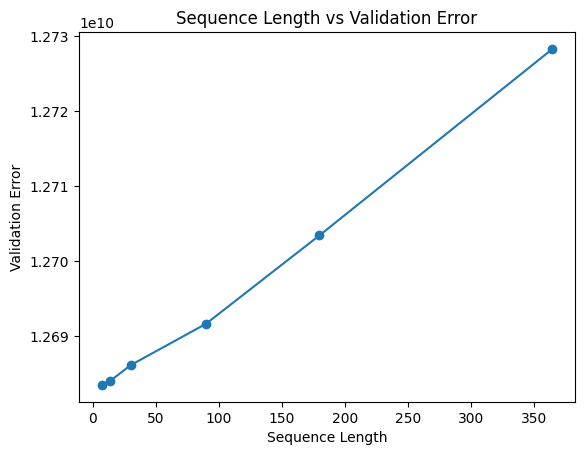

In [28]:
plt.plot(sequence_lengths_dec_5, [results_dec_5[seq] for seq in sequence_lengths_dec_5], marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Validation Error')
plt.title('Sequence Length vs Validation Error')
plt.show()

# Multiple Linear Regression

In [3]:
def run_multi_lin_reg(data, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {}
    
    num_models = 20 * n_splits
    with tqdm(total=num_models, desc='Starting the Werk 💼', colour='pink') as pbar:
        for zone in range(1,21):
            zone_data = loader_functions.load_zone_data(zone=zone, data=data)
            y = zone_data['load']
            X = zone_data.drop('load', axis=1).copy()

            errors = []
    
            split_counter = 0
            for train_idx, val_idx in tscv.split(X):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

                split_counter+=1
                pbar.set_description(f'zone: {zone}/20 Training Model {split_counter}/{n_splits} 🏋️‍♂️')

                model = LinearRegression()
                model.fit(X_train, y_train)

                y_pred = model.predict(X_val)

                rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                errors.append(rmse)

                pbar.update(1)
            results[zone] = np.mean(errors)
        pbar.set_description('finished!')
        return results

In [4]:
mlr_results = run_multi_lin_reg(data, n_splits=10)

Starting the Werk 💼:   0%|          | 0/200 [00:00<?, ?it/s]

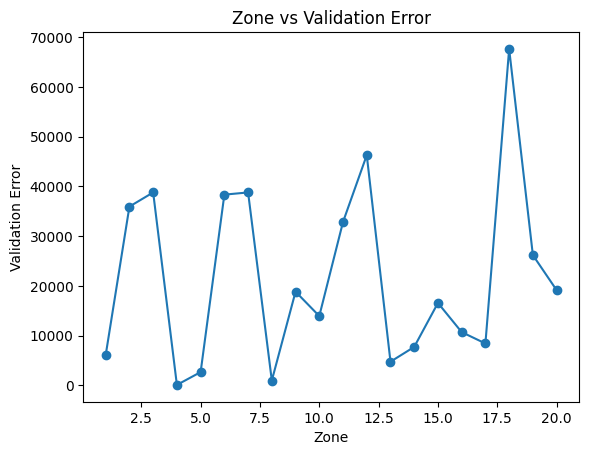

In [26]:
plt.plot(range(1,21), [mlr_results[zone] for zone in range(1,21)], marker='o')
plt.xlabel('Zone')
plt.ylabel('Validation Error')
plt.title('Zone vs Validation Error')
plt.show()

# Engineered Features

In [4]:
def add_lag_features(df, column, lags):
    for lag in lags:
        df[f"{column}_lag_{lag}"] = df[column].shift(lag)
    return df

def add_rolling_avg_features(df, column, windows):
    for window in windows:
        df[f"{column}_rolling_avg_{window}"] = df[column].rolling(window).mean()
    df.fillna(0, inplace=True)
    return df

def add_time_features(df):
    """
    Adds time-based features to the dataframe based on the index (assumed to be datetime).
    Parameters:
        df (pd.DataFrame): The input dataframe.
    Returns:
        pd.DataFrame: The dataframe with time-based features added.
    """
    # Ensure the index is datetime
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        raise ValueError("Index must be of datetime type")
    
    # Extracting features from datetime index
    df['hour'] = df.index.hour  # Hour of the day
    df['day_of_week'] = df.index.dayofweek  # Day of the week (0 = Monday, 6 = Sunday)
    df['month'] = df.index.month  # Month (1 = January, 12 = December)
    df['quarter'] = df.index.quarter  # Quarter of the year (1-4)
    df['year'] = df.index.year  # Year

    return df

def add_engineered_features(df, config, standardize_columns=None):
    """
    Adds engineered features, holiday flags, and standardizes specified columns.
    Assumes that datetime is always the index column.
    Parameters:
        df (pd.DataFrame): The input dataframe.
        config (dict): Configuration dictionary with feature parameters.
        standardize_columns (list): List of columns to standardize.
    Returns:
        pd.DataFrame: The dataframe with standardized columns and engineered features.
    """
    # Standardize specified columns
    if standardize_columns:
        scaler = StandardScaler()
        df[standardize_columns] = scaler.fit_transform(df[standardize_columns])

    # Add lag features
    if "lag" in config:
        for col, lags in config["lag"].items():
            df = add_lag_features(df, col, lags)

    # Add rolling averages
    if "rolling_avg" in config:
        for col, windows in config["rolling_avg"].items():
            df = add_rolling_avg_features(df, col, windows)

    # Add time features if the flag is True
    if config.get("add_time_features", False):
        df = add_time_features(df)

    return df

In [5]:
# List of column names
stations = [f"station_{i}" for i in range(1, 12)]
zones = [f"zone_{i}" for i in range(1, 21)]

# Configuration for engineered features
config = {
    "lag": {col: [1, 2, 3] for col in stations},  # Lags for all station columns
    "rolling_avg": {col: [3, 6, 12] for col in stations},  # Rolling averages
    "add_time_features": True,  # Turn time-based features on/off
}

# Columns to standardize (all station columns together)
columns_to_standardize = stations

engineered_data = add_engineered_features(data, config, standardize_columns=columns_to_standardize)

In [6]:
engineered_data

,zone_1,zone_2,zone_3,zone_4,zone_5,zone_6,zone_7,zone_8,zone_9,zone_10,zone_11,zone_12,zone_13,zone_14,zone_15,zone_16,zone_17,zone_18,zone_19,zone_20,station_1,station_2,station_3,station_4,station_5,station_6,station_7,station_8,station_9,station_10,station_11,station_1_lag_1,station_1_lag_2,station_1_lag_3,station_2_lag_1,station_2_lag_2,station_2_lag_3,station_3_lag_1,station_3_lag_2,station_3_lag_3,station_4_lag_1,station_4_lag_2,station_4_lag_3,station_5_lag_1,station_5_lag_2,station_5_lag_3,station_6_lag_1,station_6_lag_2,station_6_lag_3,station_7_lag_1,station_7_lag_2,station_7_lag_3,station_8_lag_1,station_8_lag_2,station_8_lag_3,station_9_lag_1,station_9_lag_2,station_9_lag_3,station_10_lag_1,station_10_lag_2,station_10_lag_3,station_11_lag_1,station_11_lag_2,station_11_lag_3,station_1_rolling_avg_3,station_1_rolling_avg_6,station_1_rolling_avg_12,station_2_rolling_avg_3,station_2_rolling_avg_6,station_2_rolling_avg_12,station_3_rolling_avg_3,station_3_rolling_avg_6,station_3_rolling_avg_12,station_4_rolling_avg_3,station_4_rolling_avg_6,station_4_rolling_avg_12,station_5_rolling_avg_3,station_5_rolling_avg_6,station_5_rolling_avg_12,station_6_rolling_avg_3,station_6_rolling_avg_6,station_6_rolling_avg_12,station_7_rolling_avg_3,station_7_rolling_avg_6,station_7_rolling_avg_12,station_8_rolling_avg_3,station_8_rolling_avg_6,station_8_rolling_avg_12,station_9_rolling_avg_3,station_9_rolling_avg_6,station_9_rolling_avg_12,station_10_rolling_avg_3,station_10_rolling_avg_6,station_10_rolling_avg_12,station_11_rolling_avg_3,station_11_rolling_avg_6,station_11_rolling_avg_12,hour,day_of_week,month,quarter,year
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,16853.0,126259.0,136233.0,484.0,6829.0,133088.0,136233.0,3124.0,75243.0,23339.0,90700.0,118378.0,20673.0,21791.0,65970.0,28752.0,30645.0,200946.0,82298.0,79830.0,-0.801973,-0.947918,-0.668399,-0.859423,-0.817688,-0.849302,-0.758880,-0.899269,-0.859550,-0.952513,-1.043719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0,3,1,1,2004
2004-01-01 01:00:00,16450.0,123313.0,133055.0,457.0,6596.0,129909.0,133055.0,2956.0,67368.0,22100.0,86699.0,112480.0,19666.0,21400.0,64600.0,27851.0,30461.0,195835.0,79827.0,77429.0,-0.801973,-1.063287,-0.782493,-0.974850,-0.817688,-0.908105,-0.814837,-0.842767,-0.971668,-0.894832,-1.268072,-0.801973,0.000000,0.000000,-0.947918,0.000000,0.000000,-0.668399,0.000000,0.000000,-0.859423,0.000000,0.000000,-0.817688,0.000000,0.000000,-0.849302,0.000000,0.000000,-0.758880,0.000000,0.000000,-0.899269,0.000000,0.000000,-0.859550,0.000000,0.000000,-0.952513,0.000000,0.000000,-1.043719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,3,1,1,2004
2004-01-01 02:00:00,16517.0,119192.0,128608.0,450.0,6525.0,125717.0,128608.0,2953.0,64050.0,21376.0,84243.0,108435.0,19020.0,20998.0,63843.0,27631.0,30197.0,194093.0,77728.0,75558.0,-0.861968,-1.120971,-0.896587,-1.090277,-0.931719,-0.966908,-0.982708,-0.955772,-1.139846,-0.894832,-1.324160,-0.801973,-0.801973,0.000000,-1.063287,-0.947918,0.000000,-0.782493,-0.668399,0.000000,-0.974850,-0.859423,0.000000,-0.817688,-0.817688,0.000000,

In [7]:
def keep_one_zone(df, zone_to_keep="zone_1"):
    """
    Drops all zone columns from the dataframe except the specified one.
    Parameters:
        df (pd.DataFrame): The input dataframe with zone columns.
        zone_to_keep (str): The name of the zone column to keep (default: 'zone_1').
    Returns:
        pd.DataFrame: The dataframe with only the specified zone column.
    """
    # Find all columns that start with 'zone'
    zone_columns = [col for col in df.columns if col.startswith('zone')]
    
    # Drop all zone columns except the one specified
    zone_columns.remove(zone_to_keep)  # Ensure we keep the specified zone
    df.drop(columns=zone_columns, inplace=True)
    
    return df

def create_sequences(data, sequence_length):
    # Get the total number of sequences
    num_sequences = len(data) - sequence_length
    
    # Pre-allocate arrays for X and y
    X = np.empty((num_sequences, sequence_length, data.shape[1] - 1))  # Exclude response column
    y = np.empty(num_sequences)
    
    # Fill in the X and y arrays
    with tqdm(total=num_sequences, desc=f'Slicing Sequences of Length {sequence_length} 💅🔪', colour='purple') as pbar:
        for i in range(num_sequences):
            X[i] = data.iloc[i:i + sequence_length, 1:].values  # Predictors
            y[i] = data.iloc[i + sequence_length, 0]  # Response
            pbar.update(1)
    
    return X, y

In [8]:
def cv_seq_len_single(data, zone, sequence_lengths, n_splits=5, full=True, show_pbar=True):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    results = {}
    full_results = pd.DataFrame(columns=['seq_len', 'RMSE'])

    zone_data = keep_one_zone(data, zone_to_keep=zone)
    
    seq_counter = 0
    num_models = len(sequence_lengths) * n_splits + len(sequence_lengths)
    with tqdm(total=num_models, desc='Starting the Werk 💼', colour='pink') as pbar:
        for seq_len in sequence_lengths:
            if show_pbar:
                seq_counter += 1
                pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Starting the Werk 🔨')
            
            zone_results = []
            zone_rows = []
            
            if show_pbar:
                pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Constructing Dataset 🚧')
                
            # construct dataset
            X, y = create_sequences(zone_data, seq_len)
            
            if show_pbar:
                pbar.update(1)
            
            errors = []

            split_counter = 0
            for train_idx, val_idx in tscv.split(X):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]

                if show_pbar:
                    split_counter+=1
                    pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Training Model {split_counter}/{n_splits} 🏋️‍♂️')
                # Build and train the model
                model = lstm_cnn(seq_len, X.shape[2])
                model.fit(X_train, y_train, epochs=5, verbose=0)  # Adjust epochs as needed
                if show_pbar:
                    pbar.update(0.5)
                    pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Evaluating Model {split_counter}/{n_splits} 🎯')
    
                # Evaluate the model
                y_pred = model.predict(X_val, verbose=0)
                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(y_val, y_pred))
                errors.append(rmse)
                if show_pbar:
                    pbar.update(0.5)
    
            # Average validation error for this sequence length on this zone
            zone_results.append(np.mean(errors))
            if full:
                zone_rows.append({'seq_len': seq_len, 'RMSE': zone_results[-1]})
            
            # Average validation error for this sequence length
            if show_pbar:
                pbar.set_description(f'seq_len: {seq_len} ({seq_counter}/{len(sequence_lengths)}) Saving Results 💾')
            results[seq_len] = np.mean(zone_results)
            if full:
                new_df = pd.DataFrame(zone_rows)
                full_results = pd.concat([full_results, new_df], ignore_index=True)
            if show_pbar:
                pbar.update(1)
    if show_pbar:
        pbar.set_description(f'Finishing Off 📓')
    return results, full_results

In [9]:
sequence_lengths = [24, 168, 720]
short_results, full_results = cv_seq_len_single(engineered_data, 'zone_1', sequence_lengths, full=True)

Starting the Werk 💼:   0%|          | 0/18 [00:00<?, ?it/s]

Slicing Sequences of Length 24 💅🔪:   0%|          | 0/38046 [00:00<?, ?it/s]

/var/folders/8p/n7h1f0bs5p76sqs_h3lhg9ph0000gn/T/ipykernel_1831/480111517.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  full_results = pd.concat([full_results, new_df], ignore_index=True)


Slicing Sequences of Length 168 💅🔪:   0%|          | 0/37902 [00:00<?, ?it/s]

Slicing Sequences of Length 720 💅🔪:   0%|          | 0/37350 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
full_results

,seq_len,zone_id,RMSE
0,24,NaN,19599.110852
